<a href="https://colab.research.google.com/github/akshay-gupta123/Resnet/blob/master/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import pandas as od
import os

Using TensorFlow backend.


In [0]:
num_classes = 10

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 10)


In [0]:
def lr_schedule(epoch):
    lr = 1e-1
    if epoch >=35:
      lr *= 5e-3
    elif epoch >=25:
      lr*=1e-2
    elif epoch >=15:
      lr*=1e-1

    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
           
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='glorot_normal',
                  kernel_regularizer=l2(0.01))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
model_1 = resnet_v2(input_shape=input_shape, depth=38)

In [0]:
model_1.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.9,decay=.005,learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model_1.summary()

Learning rate:  0.1
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 32, 32, 16)   448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 32, 32, 16)   64          conv2d_110[0][0]                 
__________________________________________________________________________________________________
activation_103 (Activation)     (None, 32, 32, 16)   0           batch_normalization_104[0][0]    
________________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_v2_model.{epoch:02d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=2,
                               patience=3,
                               modec='auto',
                               verbose=1,
                               min_lr=1e-4)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


In [0]:
history = model_1.fit(x_train, y_train,
              batch_size= 64,
              epochs=40,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
Learning rate:  0.1
50000/50000 [==============================] - 133s 3ms/step - loss: 3.3396 - accuracy: 0.3604 - val_loss: 2.9493 - val_accuracy: 0.1944

Epoch 00001: val_accuracy improved from -inf to 0.19440, saving model to /content/saved_models/cifar10_ResNet26v1_model.001.h5
Epoch 2/40
Learning rate:  0.1
50000/50000 [==============================] - 125s 3ms/step - loss: 1.6164 - accuracy: 0.4979 - val_loss: 3.0779 - val_accuracy: 0.1884

Epoch 00002: val_accuracy did not improve from 0.19440
Epoch 3/40
Learning rate:  0.1
50000/50000 [==============================] - 125s 2ms/step - loss: 1.4180 - accuracy: 0.5832 - val_loss: 1.7686 - val_accuracy: 0.4732

Epoch 00003: val_accuracy improved from 0.19440 to 0.47320, saving model to /content/saved_models/cifar10_ResNet26v1_model.003.h5
Epoch 4/40
Learning rate:  0.1
50000/50000 [==============================] - 124s 2ms/step - loss: 1.2963 - accuracy: 0.6321 - val

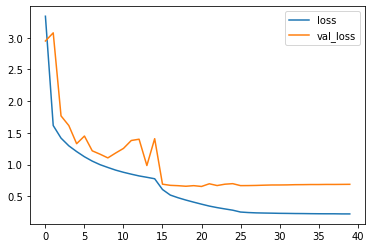

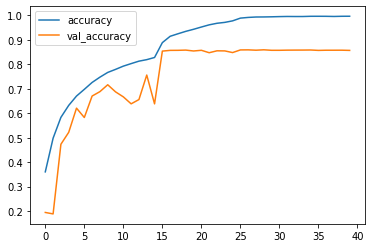

In [0]:
history_df = od.DataFrame(history.history) 
history_df[['loss', 'val_loss']].plot()
history_df = od.DataFrame(history.history) 
history_df[['accuracy', 'val_accuracy']].plot()

In [0]:
model_2 = resnet_v1(input_shape=input_shape, depth=26)

In [0]:
model_2.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum=0.9,decay=.005,learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model_2.summary()

Learning rate:  0.1
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_141 (BatchN (None, 32, 32, 16)   64          conv2d_150[0][0]                 
__________________________________________________________________________________________________
activation_140 (Activation)     (None, 32, 32, 16)   0           batch_normalization_141[0][0]    
________________________________________________________________________

In [0]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_v1_model.{epoch:02d}.h5' 
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [0]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown=2,
                               patience=3,
                               modec='auto',
                               verbose=1,
                               min_lr=1e-4)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [0]:
history_1 = model_2.fit(x_train, y_train,
              batch_size= 64,
              epochs=40,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
Learning rate:  0.1
50000/50000 [==============================] - 50s 1ms/step - loss: 1.0091 - accuracy: 0.7487 - val_loss: 1.8476 - val_accuracy: 0.4969

Epoch 00001: val_accuracy improved from -inf to 0.49690, saving model to /content/saved_models/cifar10_v2_model.001.h5
Epoch 2/40
Learning rate:  0.1
50000/50000 [==============================] - 50s 1ms/step - loss: 0.9577 - accuracy: 0.7668 - val_loss: 1.5891 - val_accuracy: 0.5972

Epoch 00002: val_accuracy improved from 0.49690 to 0.59720, saving model to /content/saved_models/cifar10_v2_model.002.h5
Epoch 3/40
Learning rate:  0.1
50000/50000 [==============================] - 50s 1ms/step - loss: 0.9165 - accuracy: 0.7827 - val_loss: 1.4494 - val_accuracy: 0.6259

Epoch 00003: val_accuracy improved from 0.59720 to 0.62590, saving model to /content/saved_models/cifar10_v2_model.003.h5
Epoch 4/40
Learning rate:  0.1
50000/50000 [==============================] - 50s 1

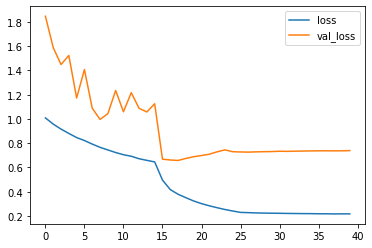

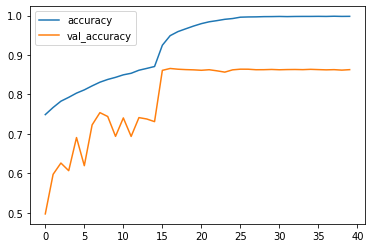

In [0]:
history_df = od.DataFrame(history_1.history) 
history_df[['loss', 'val_loss']].plot()
history_df = od.DataFrame(history_1.history) 
history_df[['accuracy', 'val_accuracy']].plot()